# TidyMongo
Make Mongo collections useful for data analysis by converting them to "tidy" pandas data frames

**References**

* [Tidy Data](http://vita.had.co.nz/papers/tidy-data.pdf)
* [Pandas](http://pandas.pydata.org/)

Querying mongo, we get lists of dictionaries.  Although this is flexible, is difficult to use for data analysis. Not to mention, our mongo collections containing nested data structures that are painful to parse.  

In [41]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client.xometry

db.orders.find_one()

{u'_constructed': datetime.datetime(2015, 2, 4, 16, 38, 57, 444000),
 u'_deleted': False,
 u'_id': u'0000-10000',
 u'_updated': datetime.datetime(2016, 2, 1, 7, 49, 36, 651000),
 u'assembly_required': False,
 u'history': [{u'_cls': u'OrderHistory',
   u'status': u'RFQ',
   u'time': datetime.datetime(2015, 2, 4, 16, 38, 57, 444000)},
  {u'_cls': u'OrderHistory',
   u'status': u'Auto-Quoted',
   u'time': datetime.datetime(2015, 2, 4, 16, 38, 57, 758000)}],
 u'line_items': {u'discount': 0.0,
  u'points_earned': 0.0,
  u'points_redeemed': 0,
  u'shipping': 0.0,
  u'tax': 0.0},
 u'parts': [{u'_id': ObjectId('56af0e109b724741d713f58d'),
   u'finish': ObjectId('543ef1f380da5b0c476373bf'),
   u'history': [{u'_cls': u'AdditivePartHistory',
     u'status': u'RFQ',
     u'time': datetime.datetime(2015, 2, 4, 16, 38, 57, 444000)},
    {u'_cls': u'AdditivePartHistory',
     u'status': u'Auto-Quoted',
     u'time': datetime.datetime(2015, 2, 4, 16, 38, 57, 757000)}],
   u'material': ObjectId('543303

Yuck!!!

## Enter TidyMongo

Tool to normalize mongo collection into relational, normalized pandas dataframes

In [34]:
from tidymongo import tidy
tables = tidy(db.orders.find().limit(100), 'orders')
tables

TidyResult(tables=[u'line_items', u'shipping', 'orders', u'parts', u'payment', u'history'])

In [40]:
tables.orders.head(n=2)

,_constructed,_deleted,_updated,assembly_required,coupon,due_date,notes,order_time,subtotal,total,user,user_email
_id,,,,,,,,,,,,
0000-10000,2015-02-04 16:38:57.444,False,2016-02-01 07:49:36.651,False,NaN,NaN,NaN,NaN,17.38,17.38,NaN,NaN
0000-10001,2016-02-03 22:46:50.000,False,2016-02-03 22:47:47.000,False,NaN,NaN,NaN,NaN,54.96,54.96,NaN,xuejianw@gmail.com


Nested document collections are split out to new dataframes with a foreign key columns (orders)

In [38]:
tables.parts.head(n=2)

,_cls,finish,history,material,orders,part,production,quantity_ordered,quantity_shipped,quote,revision_num
_id,,,,,,,,,,,
56af0e109b724741d713f58d,NaN,543ef1f380da5b0c476373bf,"[{u'status': u'RFQ', u'_cls': u'AdditivePartHi...",5433037a80da5b2331e9722f,0000-10000,A3FC,NaN,1,0,"{u'manual': False, u'extended_price': 17.38}",0
56b2835a9821cc4cf91ff303,NaN,543ef1f380da5b0c476373bf,"[{u'status': u'RFQ', u'_cls': u'PartHistory', ...",5594427d065c1461694a4caf,0000-10001,0018B37,NaN,1,0,"{u'manual': False, u'extended_price': 10.17}",0


In [39]:
tables.shipping.head(n=2)

,account_number,address,bill_receiver,fob,method,orders,service,shipments
0,NaN,NaN,False,False,ground,0000-10000,ups,[]
1,NaN,NaN,False,False,ground,0000-10001,ups,[]


## Example: Show the Distribution of Quanity of Parts Shipped for orders in April

In [65]:
from datetime import datetime

orders = db.orders.find({
    '_constructed': {
        '$gte': datetime(2016, 4, 1),
        '$lt': datetime(2016, 5, 1)
    }
})

tables = tidy(data=orders, observational_unit='orders')
tables

TidyResult(tables=[u'line_items', u'shipping', 'orders', u'parts', u'shared_users', u'lead_time', u'payment', u'history'])

In [66]:
tables.parts.quantity_shipped.describe()

count    6792.000000
mean        0.791225
std        13.117751
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       999.000000
Name: quantity_shipped, dtype: float64

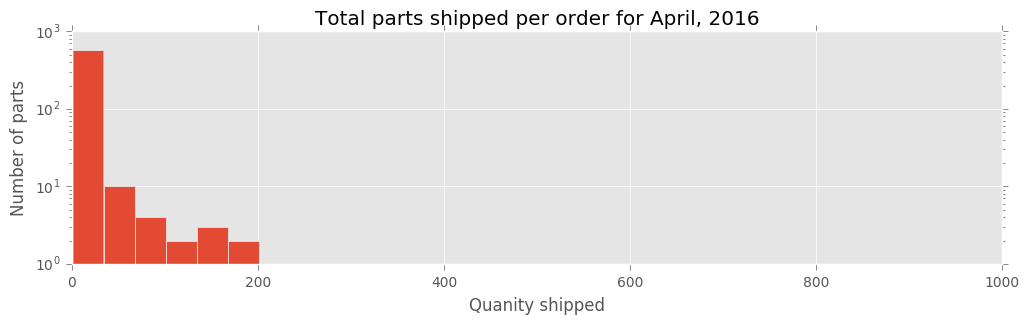

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 3))
    plt.title('Total parts shipped per order for April, 2016')
    plt.ylabel('Number of parts')
    plt.xlabel('Quanity shipped')
    
    shipped = tables.parts.groupby('orders').quantity_shipped.sum()
    shipped[shipped > 0].hist(log=True, bins=30)
    
    plt.show()